Meta-learners (T-Learner, SLearner, X-Learner) による因果推論

In [11]:
# 乱数シード
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *
# グラフの描画用
import matplotlib.pyplot as plt
import japanize_matplotlib

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats
# シグモイド関数をimport
from scipy.special import expit
# その他
import pandas as pd

# 自作データの作成

Text(0, 0.5, '研修効果の大きさt(x)')

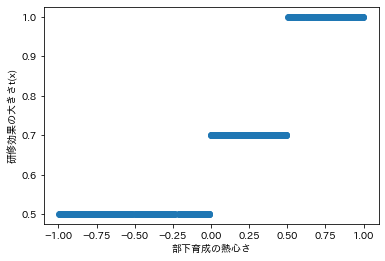

In [12]:
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)

# 上司が「研修に参加」したかどうか
e_z = randn(num_data)
z_prob = expit(5.0*x+5*e_z) # 熱心である程参加しやすい
Z = np.array([])

for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)
    
# 介入効果の「非線形性」: 部下育成の熱心さxの値に応じて
# 研修効果は段階的（今回は特に離散的）に変化するとする
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

# 部下育成の熱心さに対する研修効果の可視化
## 熱心であれば効果が非線形に高くなるとする
plt.scatter(x, t )
plt.xlabel('部下育成の熱心さ')
plt.ylabel('研修効果の大きさt(x)')

In [13]:
# 満足度
e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y

## 満足度Yの可視化

In [16]:
df = pd.DataFrame({
    'x': x,
    'Z': Z,
    't': t,
    'Y': Y,
})

In [17]:
df.head()

,x,Z,t,Y
0,-0.616961,0.0,0.5,1.803183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,1.0,1.0,3.245229
4,0.559952,1.0,1.0,3.139868


Text(0, 0.5, '面談の満足度Y')

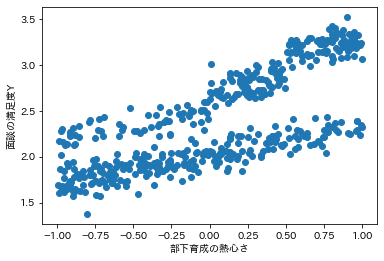

In [18]:
plt.scatter(x, Y)
plt.xlabel('部下育成の熱心さ')
plt.ylabel('面談の満足度Y')

# T-Learner

TはTwoの意で，2つの機械学習モデルを使う

2つは，
- 介入を受けた集団（Z=0）
- 介入を受けていない集団（Z=1）

In [19]:
# 集団を2つに分ける
df_0 = df[df.Z == 0.0]
df_1 = df[df.Z == 1.0]

In [20]:
# ランダムフォレストモデル
from sklearn.ensemble import RandomForestRegressor

# 介入を受けていないモデル
reg_0 = RandomForestRegressor(max_depth=3)
reg_0.fit(df_0[['x']], df_0[['Y']])

# 介入を受けたモデル
reg_1 = RandomForestRegressor(max_depth=3)
reg_1.fit(df_1[['x']], df_1[['Y']])

<ipython-input-20-03462fb1e144>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_0.fit(df_0[['x']], df_0[['Y']])
<ipython-input-20-03462fb1e144>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_1.fit(df_1[['x']], df_1[['Y']])


RandomForestRegressor(max_depth=3)

## ATE

In [21]:
mu_0 = reg_0.predict(df[['x']])
mu_1 = reg_1.predict(df[['x']])

ATE = (mu_1-mu_0).mean()
print('ATE: ', ATE)

ATE:  0.6678485877933638


In [22]:
# 処置群における平均処置効果ATTと
# 対照群における平均処置効果ATU
ATT = df_1['Y'] - reg_0.predict(df_1[['x']])
ATU = reg_1.predict(df_0[['x']]) - df_0['Y']

print('ATT: ', ATT.mean())
print('ATU: ', ATU.mean())

ATT:  0.7338369884256869
ATU:  0.6090862934128768


## 推定された処置効果を各人ごとに求める

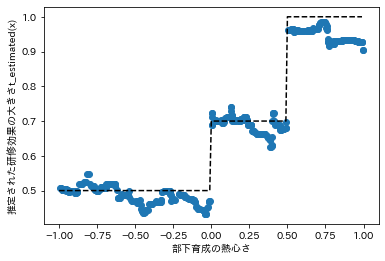

In [24]:
t_estimated = reg_1.predict(df[['x']]) - reg_0.predict(df[['x']])
plt.scatter(df[['x']], t_estimated)
plt.xlabel('部下育成の熱心さ')
plt.ylabel('推定された研修効果の大きさt_estimated(x)')


# 正解のグラフを重畳
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0
        
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

正解である破線に対して，正しく介入効果を推定できていることがわかる

# S-Learner

SはSingle. モデルは1つであり，介入変数Zも説明変数の中に入れる．

今回モデルはランダムフォレストを使うが，別モデルでも良い．

In [25]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# モデルを学習
reg = RandomForestRegressor(max_depth=4)
X = df.loc[:, ['x', 'Z']]
reg.fit(X, df[['Y']])

<ipython-input-25-0c79f6199100>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, df[['Y']])


RandomForestRegressor(max_depth=4)

## ATE

In [27]:
# 処置が0/1の状態を作成する
X_0 = X.copy()
X_0['Z'] = 0.0

X_1 = X.copy()
X_1['Z'] = 1.0

# ATE
ATE = (reg.predict(X_1)-reg.predict(X_0)).mean()
print('ATE: ', ATE)

ATE:  0.667734812161322


## 推定された処置効果を各人ごとに求める

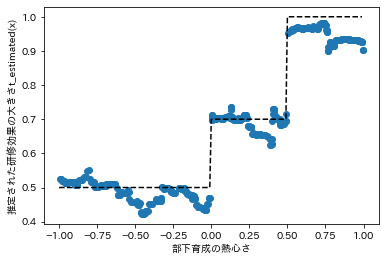

In [29]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg.predict(X_1)-reg.predict(X_0)
plt.scatter(df[['x']], t_estimated)
plt.xlabel('部下育成の熱心さ')
plt.ylabel('推定された研修効果の大きさt_estimated(x)')

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

# X-Learner

T-Learnerを「傾向スコア」を使ってさらに補正する．  
特に，T-Leanerでは介入あり/なしで明確にユーザが分類されてしまうので，傾向スコアを使って自分のデータ「ではない方」のモデルの重みを強くすることで，全体としてのモデルの精度を向上させようという試み．

In [30]:
# T-LearnerでM0/M1（介入あり/なしに対するモデル）を求める
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]
df_1 = df[df.Z == 1.0]

# 介入を受けていないモデル
M0 = RandomForestRegressor(max_depth=3)
M0.fit(df_0[['x']], df_0['Y'])

# 介入を受けているモデル
M1 = RandomForestRegressor(max_depth=3)
M1.fit(df_1[['x']], df_1['Y'])

RandomForestRegressor(max_depth=3)

In [31]:
# 推定された介入効果を各人ごとに求める
# T-LearnerでいうATU/ATTだが，後続でここにモデルを入れる
tau_0 = M1.predict(df_0[['x']]) - df_0['Y'] # （仮の）ATU
tau_1 = df_1['Y'] - M0.predict(df_1[['x']]) #（仮の）ATT

# ATTとATUを求めるモデルを作成する
M2 = RandomForestRegressor(max_depth=3)
M2.fit(df_0[['x']], tau_0)

M3 = RandomForestRegressor(max_depth=3)
M3.fit(df_1[['x']], tau_1)

RandomForestRegressor(max_depth=3)

In [32]:
# 傾向スコア（介入に対する傾向）の算出
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[['x']]

# 目的変数
Z = df['Z']

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

# それぞれのモデルで全データの効果を予測し，
# 傾向スコアで調整
tau = g_x_val[:, 1]*M2.predict(df[['x']]) + g_x_val[:, 0]*M3.predict(df[['x']])

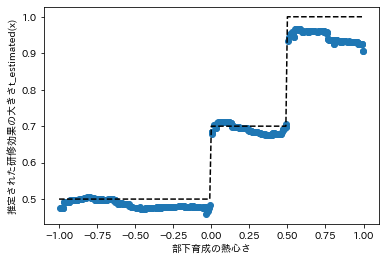

In [33]:
# 推定された介入効果を各人ごとに求める
plt.scatter(df[["x"]], tau)
plt.xlabel('部下育成の熱心さ')
plt.ylabel('推定された研修効果の大きさt_estimated(x)')

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')